In [26]:
import pandas as pd
import ccxt
import matplotlib.pyplot as plt
import datetime
from sklearn.model_selection import train_test_split
import xgboost as xgb
from xgboost import plot_importance
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix


In [2]:
# """ import all ETHUSDT OHLC data from Binance """
coin='ETH/USDT'
timeframe='1h'
exchange=ccxt.binance()
start_date=0
# start_date = int(datetime.datetime(2017, 1, 1, 1, 1).timestamp() * 1000)

data=pd.DataFrame(columns=['date', 'open', 'high', 'low', 'close', 'volume'])

while True:
    response=exchange.fetch_ohlcv(coin, timeframe, since=start_date, limit=1000)
    df=pd.DataFrame(response, columns=['date', 'open', 'high', 'low', 'close', 'volume'])
    updateData=pd.merge(data, df, how='outer')
    if len(data)!=len(updateData):
        data=updateData.copy()
        start_date=data['date'].iloc[-1]
    else:
        break
    
data.drop_duplicates(inplace=True)
data.date=pd.to_datetime(data['date'], unit='ms', utc=True, yearfirst=True)
print(data.head(10))

                       date    open    high     low   close     volume
0 2017-08-17 04:00:00+00:00  301.13  302.57  298.00  301.61  125.66877
1 2017-08-17 05:00:00+00:00  301.61  303.28  300.00  303.10  377.67246
2 2017-08-17 06:00:00+00:00  302.40  304.44  301.90  302.68  303.86672
3 2017-08-17 07:00:00+00:00  302.68  307.96  302.60  307.96  754.74510
4 2017-08-17 08:00:00+00:00  307.95  309.97  307.00  308.62  150.75029
5 2017-08-17 09:00:00+00:00  308.62  312.00  308.62  310.00  469.27879
6 2017-08-17 10:00:00+00:00  310.00  310.97  308.54  309.30  284.39140
7 2017-08-17 11:00:00+00:00  308.30  310.68  307.78  308.95  273.29040
8 2017-08-17 12:00:00+00:00  308.95  310.51  307.98  308.62  401.79278
9 2017-08-17 13:00:00+00:00  308.62  309.72  307.77  309.40  310.58042


In [3]:
# Calculate drawdown
HighestHigh = [data['high'].iloc[0]]
for i in range(1,len(data)):
    if data['high'].iloc[i] >= HighestHigh[-1]:
        HighestHigh.append(data['high'].iloc[i])
    else:
        HighestHigh.append(HighestHigh[-1])
        
data['HighestHigh'] = HighestHigh
data['DrawDown'] = data.apply(lambda row: 0 if row['high']==row['HighestHigh'] else (row['low']-row['HighestHigh'])*100/row['HighestHigh'], axis=1)



In [4]:
# Maximum Drawdown (MDD) 
print("Maximum Drawdown (MDD): {0} %".format(data.loc[data['DrawDown'] == min(data['DrawDown']) ,"DrawDown"].values[0].round(2)))  

Maximum Drawdown (MDD): -94.32 %


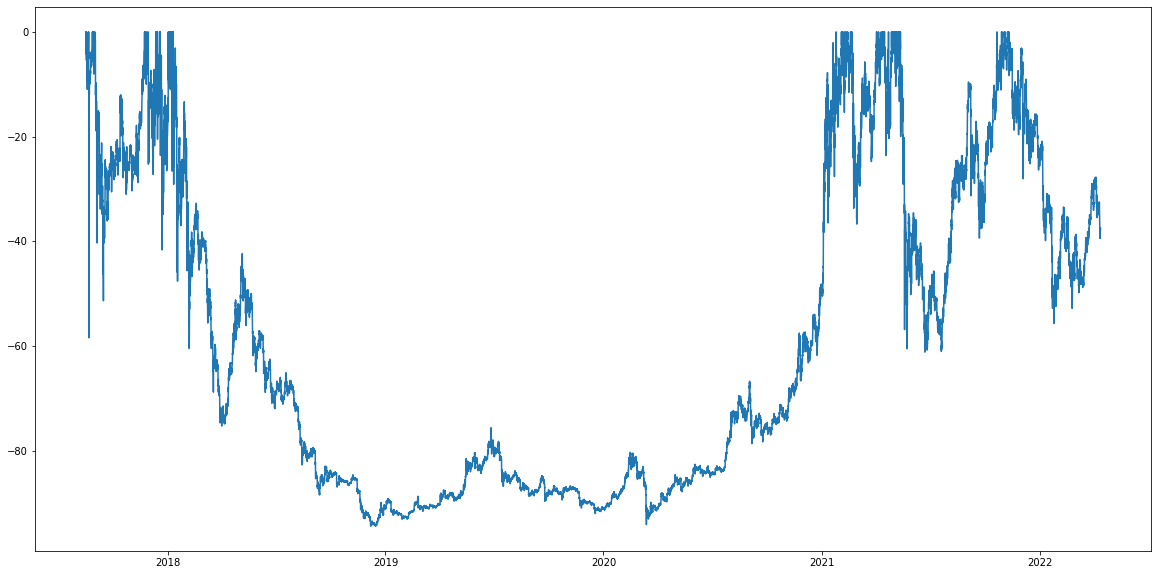

In [5]:
# plot drawdown
plt.figure(figsize=(20,10))
plt.plot(data['date'], data['DrawDown'])

In [6]:
# add important variables

for i in range(1,51):
    data['pctchange{0}'.format(i)]=data['close'].pct_change(i)

for i in range(1,51):
    data['pctchange1_{0}'.format(i)] = data['pctchange1'].shift(i)
    data['DrawDown{0}'.format(i)] = data['DrawDown'].shift(i)
print(len(data))

40665


In [7]:
# print(data['date'].dtypes)
# data['date2']=data['date'].isocalendar

data['year']=data['date'].dt.year
data['month']=data['date'].dt.month
data['day']=data['date'].dt.day
data['dayofyear']=data['date'].dt.dayofyear

data.dropna(inplace=True)
print(data.shape)


(40614, 162)


In [8]:
print(data.loc[:,['date','dayofyear']])

                           date  dayofyear
51    2017-08-19 07:00:00+00:00        231
52    2017-08-19 08:00:00+00:00        231
53    2017-08-19 09:00:00+00:00        231
54    2017-08-19 10:00:00+00:00        231
55    2017-08-19 11:00:00+00:00        231
...                         ...        ...
40660 2022-04-12 14:00:00+00:00        102
40661 2022-04-12 15:00:00+00:00        102
40662 2022-04-12 16:00:00+00:00        102
40663 2022-04-12 17:00:00+00:00        102
40664 2022-04-12 17:00:00+00:00        102

[40614 rows x 2 columns]


In [39]:
# Definig target column 
# The trading situation can earn more than 1% profit
data['target']=data['pctchange1'].apply(lambda x : 'buy' if x>0.01 else 'sell')
print(max(data['pctchange1']))
print(data['pctchange1'])

0.18079244292836538
51       0.003944
52      -0.006066
53       0.006588
54      -0.010885
55      -0.015881
           ...   
40660   -0.008076
40661    0.005787
40662   -0.000893
40663    0.000217
40664   -0.000138
Name: pctchange1, Length: 40614, dtype: float64


In [40]:
# we subset our data frame to 
X_train, X_test, y_train, y_test = train_test_split(data[data.columns.difference(['date','target'])], data['target'], test_size=0.33, random_state=42)

In [41]:
# xg_reg = xgb.XGBRegressor(objective = "reg:linear",
#                           colsample_bytree=1,
#                           learning_rate = 0.1,
#                           gamma=3,
#                           max_depth = 10,
#                           alpha=20,
#                           n_estimators =1000,
#                           min_child_weight=7,
#                           reg_alpha=1e-05,
#                           reg_lambda=1e-05,
#                           subsample=0.95)

xg_reg = xgb.XGBClassifier()

In [ ]:
xg_reg.fit( X_train, y_train )

In [ ]:
ax= plot_importance( xg_reg , height=0.9)
fig = ax.figure
fig.set_size_inches(10, 20)


In [ ]:
accuracies = cross_val_score(estimator=xg_reg, X=X_train, y=y_train, cv=10, n_jobs=1)

In [ ]:
print(accuracies.mean())
print(accuracies.std())
print(accuracies)

In [46]:
y_pred = xg_reg.predict(X_test)
cm=confusion_matrix(y_test, y_pred)

In [52]:
result = pd.DataFrame(columns=['pred','real'])
result['pred']=y_pred
result['real']=list(y_test)

In [ ]:
# print(list(y_test))
# print(result.head(50))
print(result.tail(50))